# Fitting the DGF prior to samples from the LF model

## Notation

$u \sim q(u)$ is a sample from the LF model, $p(u)$ is the evidence $Z_u$ of fitting the LF sample $u$ with one of our DGF prior models.

## The KL expression

We use a Monte Carlo approximation to calculate the KL divergence:
$$ KL(q \leftarrow p) \approx \sum_r \log q(u_r) - \log p(u_r) \geq 0 $$ where $u_r \sim q(u)$. So we require that $q(u_r) > p(u_r)$. This makes sense because a particular waveform $u$ is of course much more probable under the LF model than our nonparametric GP model.

## Getting priors for the source parameters $\theta$ from this experiment

**NEW UPDATE**: just resample the individual posteriors and pool all samples, this is theoretically valid, and fit a nonlinear coloring bijector to the pool of samples. The model is $\theta$ (DGF prior samples), $u$ (DGF waveform), $\phi$ (LF parameters).

$$ p(\theta, u, \phi) = p(\theta|u) p(u|\phi) p(\phi) $$

The goal is $p(\theta)$. So

$$ p(\theta) = \int d\phi p(\phi) \big[ \int p(\theta|u) p(u|\phi) du \big] \simeq \int d\phi p(\phi) \big[ p(\theta|u(\phi)) \big] \approx {1\over N_\phi} \sum_{\phi_i \sim p(\phi)} p(\theta|u(\phi_i)) $$

Now we resample $p(\theta|u(\phi))$ to a 100 samples, i.e., we approximate by a sum of equally-weighted delta functions:

$$ p(\theta|u(\phi_i)) \approx {1\over 100} \sum_{j=1}^{100} \delta(\theta - \theta_{ij})$$

Doing this, we have now reduced $p(\theta)$ to a big sum of $100 N_\phi$ **equally-weighted** delta functions...

$$ p(\theta) \approx {1\over 100 N_\phi} \sum_{\phi_i \sim p(\phi)} \sum_{j=1}^{100} \delta(\theta - \theta_{ij}) $$

... and we can just fit our bijector to it. So we deal with capturing probability mass by (1) Monte Carlo sampling (from $\phi_i \sim p(\phi)$) and (2) resampling the posterior $p(\theta|u(\phi_i))$ to equally weighted samples.

**UPDATE on the paragraphs below in this section:** The number of dimensions (`len(u)`) is $O(100)$, so importance sampling doesn't work, because the weights have huge outliers which dominate the expectation values. This is entirely expected. We would need a huge number of samples to get a practically usable distribution of weights where the samples of the typical set are large enough in number to compensate the relatively few samples around the likelihood mode, which dominate the weights. This intuition is formalized in a simple relation between the variance of the importance sampling estimate and the KL divergence that we have here in [Au2003, Eq. 11].

To determine $p(\theta)$ from the sampled $u \sim q(u)$, we can use importance sampling such that $p(\theta) \approx \frac{\sum_r w_r p(\theta|u_r)}{\sum_r w_r}$ where $w_r = p(u_r)/q(u_r)$ and $u_r \sim q(u)$ (MacKay 2005, p. 361). In other words, reweigh the posterior samples by the importance sampling weights $w_r$.

By relying on this approximation we implicitly assert that our prior $p(\theta)$ gives rise to DGF waveforms $p(u|\theta)$ which are already close to the "true" ones $q(u)$. And indeed, we have built in smooth opening constraint, the null integral constraint, and the OQ parameter.

We can also get some feeling, of course, for how close $p(u|\theta)$ will typically be to $q(x)$ by the $KL(q \leftarrow p)$. I say "typically" because $p(u) = \int d\theta p(u|\theta) p(\theta)$, so we indeed both rely on our DGF Hilbert model $p(u|\theta)$ *and* sensible bounds and parametrization of the prior $p(\theta)$.

Another indicator of the quality of this approximation is whether the weights $w_r$ are reasonably similar in magnitude and no extreme outliers exist. And unfortunately these do exist: While most samples $u$ have $\log q(u) \sim O(1000)$, several of them also have a $\log q(u)$ of 1 or 2 orders magnitude larger; these are extreme outliers due to boundary effects of `Qa ~= 1`.

**Something else:** once we have fitted our prior in the $z$-domain (after nonlinear whitening), we can make it conditional on $T$, which is handy when we have Praat estimates $\hat T$ for $T$ available.

## Noise floor

**UPDATE**: we just use our $\text{Log}_{10}\text{Normal}$ priors for everything. The log likelihood returns -inf when `Oq > 1`, so we impose a hard bound there, since our `core.py` implementation works fine with `Oq > 1` (the waveform gets shifted to before the starting interval and $T_0$ gets stretched out) and this can cause probable solutions for the source parameters with values of `Oq > 1`.

We add to the sample $u$ some noise to regularize the problem and install a hard lower bound $\delta^2$ for the DGF prior. This is also handy to regularize the probability $q(u)$, which we compute using a MAP approximation, thereby avoiding another nested sampling run.

The noise power term $\sigma_n^2$ of the GP is essentially a smoothing parameter because the GP won't like it to perfectly model the very sharp features of the LF waveform. It is lower bounded by the noise floor: $\sigma_n^2 \geq \delta^2$.

The "SNR" $\sigma_n^2/\delta^2$ is a good measure of the extent to which the GP went along in modeling the sharp features of the DGF waveform. In practice we can use the amount of dB above the noise floor. If the noise floor is at -60 dB, then typically $10\log_{10}(\sigma_n^2) \sim -40~dB$ so only 20 dB above the noise floor.

In [1]:
%run init.ipy
from dgf import core
from dgf import isokernels
from lib import constants
from dgf.prior import lf
from dgf.prior import source
from lib import lfmodel
from lib import klatt

import scipy.stats

2022-12-17 21:29:03.966236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-17 21:29:03.966283: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-17 21:29:03.966288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Plot the samples from the LF model

The open quotient `Oq` of the LF model correlates only moderately with the OQ as we see it. Namely we see the OQ as a "hard" close where the DGF waveform is zero. The LF model has an exponential return phase and a "soft" close such that the `Oq` is quite fuzzily defined. So we cannot expect our inferred `Oq` to correspond with the `Oq` of LF, because of this soft return phase. Our implementation of `Oq` is just dividing the pitch period into a hard zero (closed) phase and a nonzero (open) phase.

In [2]:
lf_samples = source.get_lf_samples()

[Memory]2.0s, 0.0min    : Loading get_lf_samples...


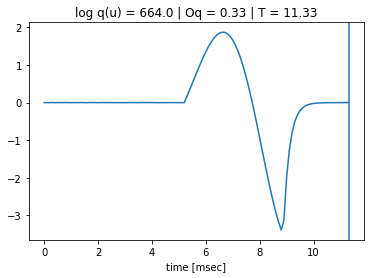

{'T0': DeviceArray(11.33042032, dtype=float64),
 'Oq': DeviceArray(0.32690574, dtype=float64),
 'am': DeviceArray(0.68762574, dtype=float64),
 'Qa': DeviceArray(0.02936922, dtype=float64),
 'Te': DeviceArray(3.70397942, dtype=float64),
 'Tp': DeviceArray(2.54695159, dtype=float64),
 'Ta': DeviceArray(0.22398262, dtype=float64)}

In [3]:
def plot_dgf(i):
    s = lf_samples[i]

    p, t, u, log_prob_u = s['p'], s['t'], s['u'], s['log_prob_u']

    plot(t, u)
    xlabel('time [msec]')
    title(f'log q(u) = {log_prob_u:.1f} | Oq = {p["Oq"]:.2f} | T = {p["T0"]:.2f}');
    axvline(p['T0']);
    show()
    display(s['p'])

plot_dgf(randint(len(lf_samples)))

Check log probability of the samples. It is quite nicely distributed -- see cell 8 in lf.ipynb.

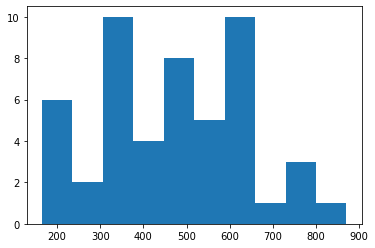

In [4]:
hist([float(s['log_prob_u']) for s in lf_samples], bins=10);

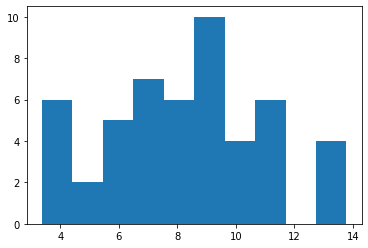

In [5]:
hist([float(s['p']['T0']) for s in lf_samples], bins=10);

## Driver

### Nested sampling uncertainties

https://dynesty.readthedocs.io/en/stable/errors.html

Two main sources:
- Statistical errors: how $\log X_i$ is estimated  
- Sampling errors: plain from Monte Carlo estimation of the integral + imperfect sampling within isocontour

It doesn't really seem worth it to use these here based on some experiments so we just go with `dynesty`'s analytical error estimate.

In [6]:
fitted = source.get_fitted_lf_samples()

[Memory]2.9s, 0.0min    : Loading get_lf_samples...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading run_nested...
[Memory]3.0s, 0.0min    : Loading ru

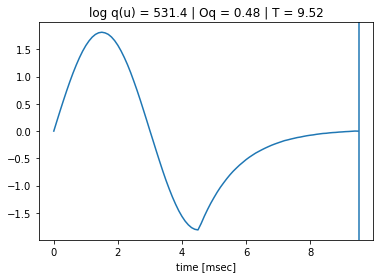

{'T0': DeviceArray(9.52348935, dtype=float64),
 'Oq': DeviceArray(0.47887724, dtype=float64),
 'am': DeviceArray(0.66509982, dtype=float64),
 'Qa': DeviceArray(0.24763526, dtype=float64),
 'Te': DeviceArray(4.56058234, dtype=float64),
 'Tp': DeviceArray(3.03324249, dtype=float64),
 'Ta': DeviceArray(1.22899075, dtype=float64)}

In [7]:
from lib import util

index = 3398
plot_dgf(fitted[index]['i'])

Summary
nlive: 25
niter: 710
ncall: 29051
eff(%):  2.530
logz: 232.486 +/-  0.968


None

'Information (bans)'

9.650218080944295

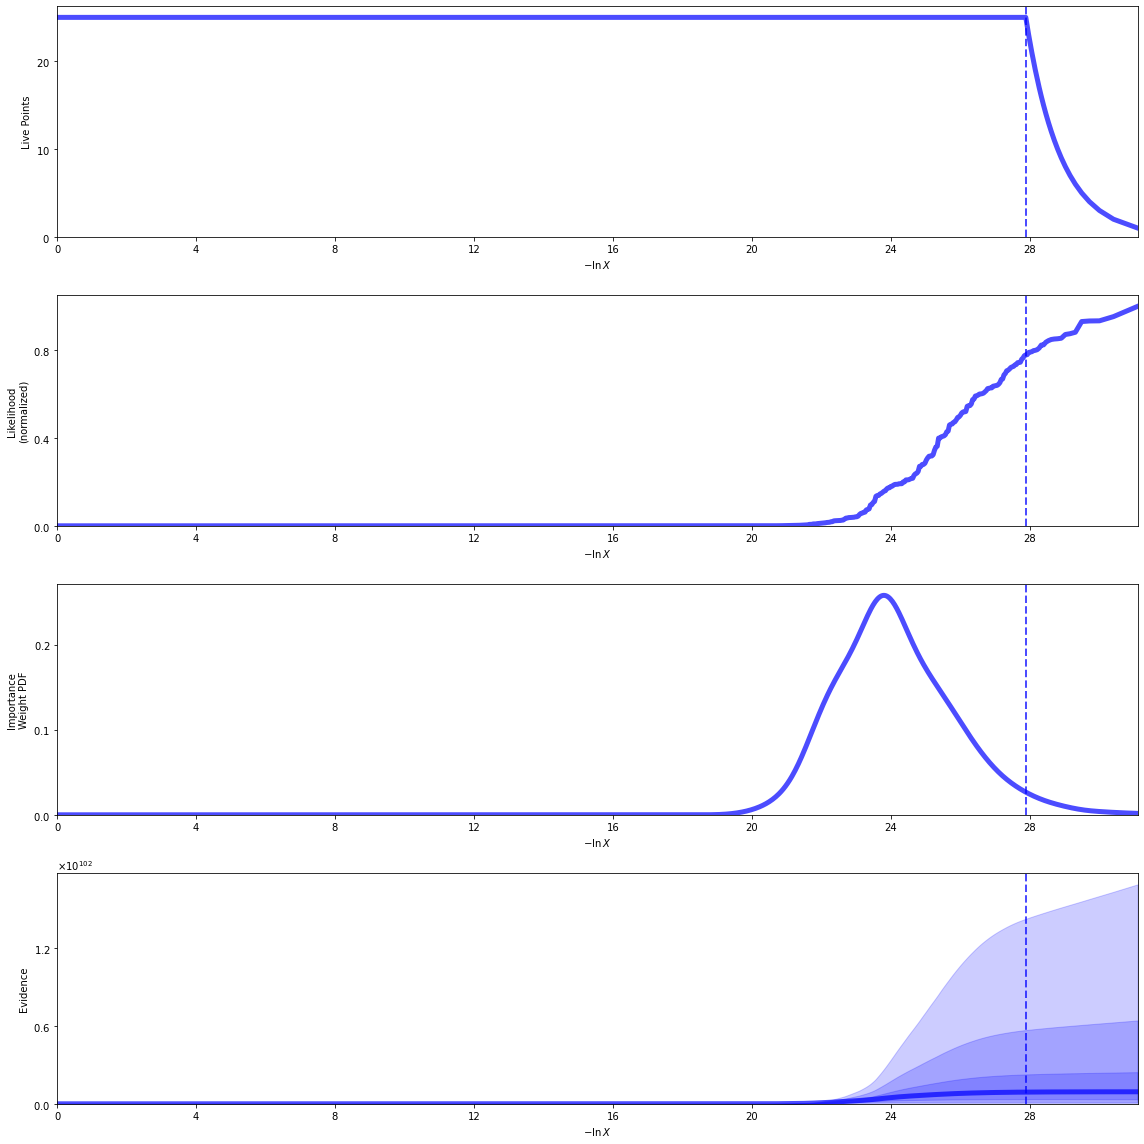

Quantiles:
noise_power_sigma [(0.025, 0.004621870279043342), (0.5, 0.005747146375516117), (0.975, 0.006915261657353644)]
Quantiles:
var_sigma [(0.025, 1.3475335217066806), (0.5, 4.580755941172745), (0.975, 43.464614028646686)]
Quantiles:
r [(0.025, 0.4085765449976951), (0.5, 0.9865809324892092), (0.975, 4.594557817505337)]
Quantiles:
T [(0.025, 8.965755814402302), (0.5, 9.170946346034194), (0.975, 9.333243523795879)]
Quantiles:
Oq [(0.025, 0.9983340616562043), (0.5, 0.9994001852718758), (0.975, 0.9999709393461467)]


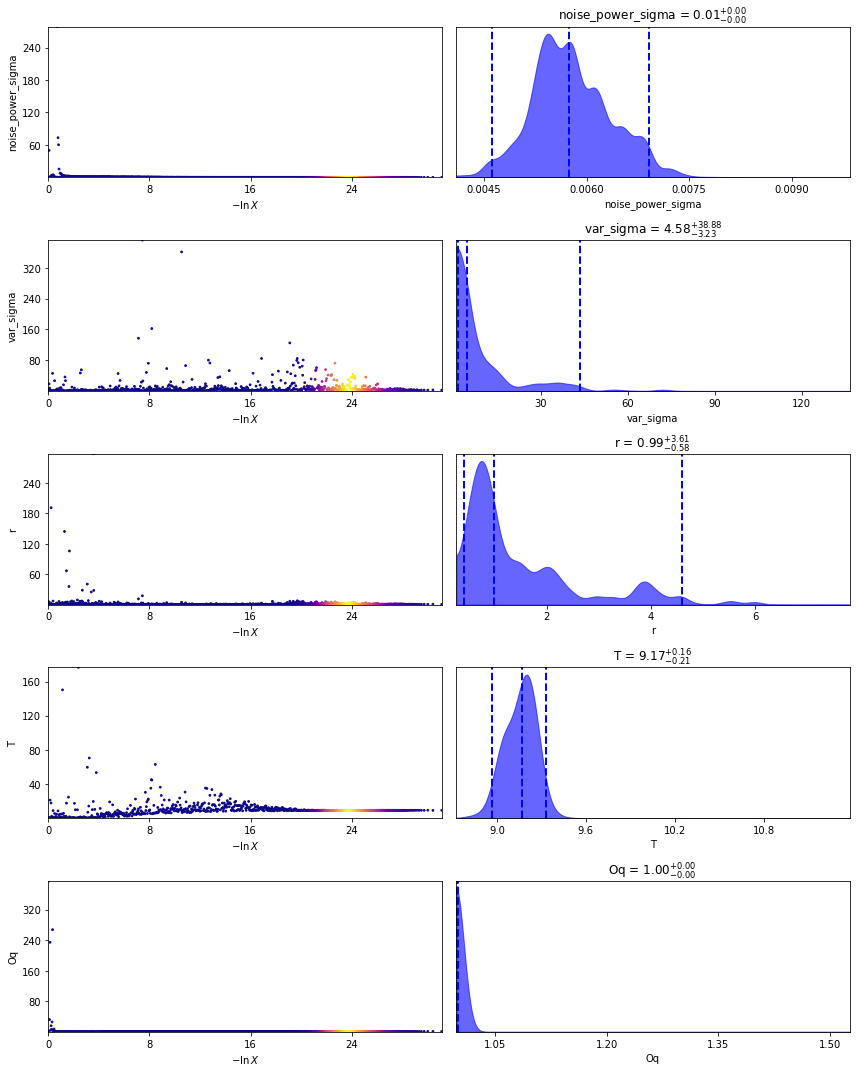

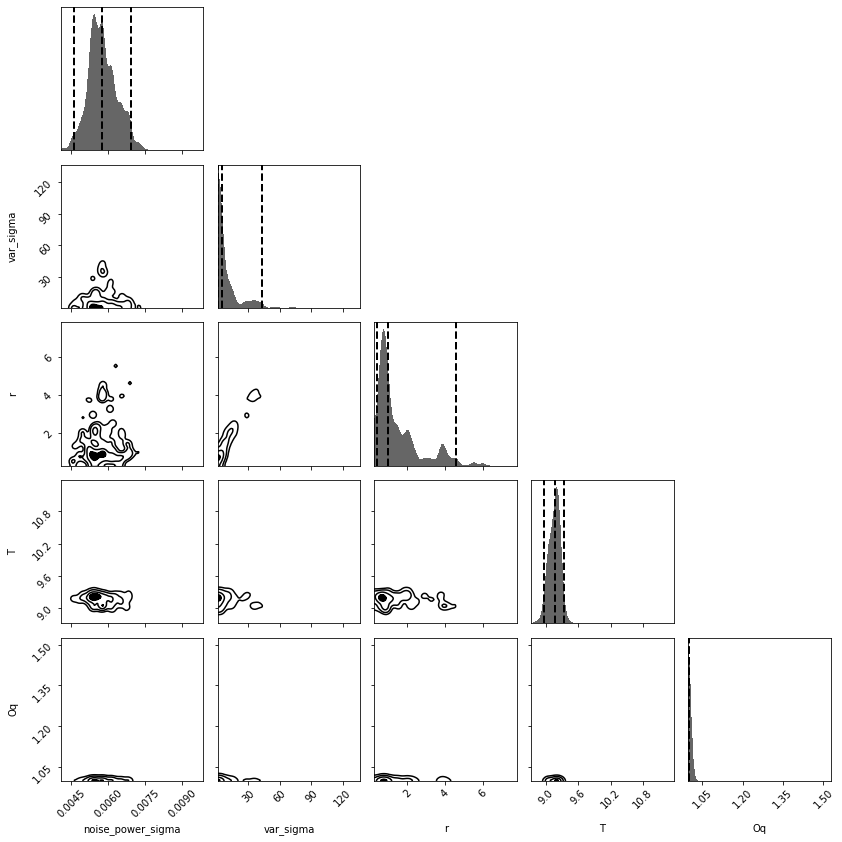

In [8]:
# noise_power_sigma, var, r, T, Oq
util.dyplot(fitted[index]['results'], source.FIT_LF_SAMPLE_PARAMS)

In [9]:
from datatable import dt, f, by, update

df = dt.Frame(source.process_fitted_lf_samples())

[Memory]12.4s, 0.2min   : Loading get_lf_samples...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading run_nested...
[Memory]12.5s, 0.2min   : Loading ru

In [10]:
df

,kernel_name,kernel_M,use_oq,impose_null_integral,cacheid,i,log_prob_p,log_prob_p_sd,log_prob_q,T0,…,r,T,Oq,SNR_q,SNR_p
,▪▪▪▪,▪▪▪▪,▪,▪,▪▪▪▪,▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪
0,Matern12Kernel,16,0,0,56751570,0,21.3727,0.624322,348.304,6.53201,…,5.07451,5.94458,1,60,20.1308
1,Matern12Kernel,16,0,1,34966660,0,24.868,0.641901,348.304,6.53201,…,3.82542,5.96118,1,60,20.0934
2,Matern12Kernel,16,1,0,77606788,0,19.9784,0.729734,348.304,6.53201,…,2.13617,5.90173,0.958148,60,20.4758
3,Matern12Kernel,16,1,1,58763949,0,21.8984,0.787016,348.304,6.53201,…,2.46408,5.90218,0.962498,60,20.6004
4,Matern32Kernel,16,0,0,17717016,0,20.6789,0.647262,348.304,6.53201,…,0.167083,5.95155,1,60,19.9316
5,Matern32Kernel,16,0,1,70192518,0,25.167,0.630939,348.304,6.53201,…,0.247429,5.95419,1,60,20.1318
6,Matern32Kernel,16,1,0,79494975,0,17.7297,0.786438,348.304,6.53201,…,0.154513,5.86465,0.960665,60,20.3662
7,Matern32Kernel,16,1,1,51093323,0,19.6529,0.839508,348.304,6.53201,…,0.244145,5.90341,0.961049,60,20.6326
8,Matern52Kernel,16,0,0,31575953,0,20.0778,0.658644,348.304,6.53201,…,0.104933,5.95151,1,60,20.1411


In [11]:
any(isnan(df[:, f.log_prob_p_sd]))

False

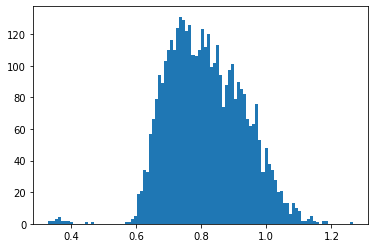

In [12]:
hist(df[:, f.log_prob_p_sd], bins=100);

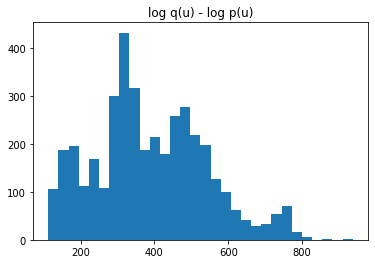

In [13]:
df[:, update(log_prob_diff = f.log_prob_q - f.log_prob_p)]

title('log q(u) - log p(u)')
hist(df['log_prob_diff'], bins=30);

(array([ 20.,   0., 238., 995., 890., 698., 532., 273., 158., 196.]),
 array([-0.14486274,  6.18668088, 12.51822449, 18.8497681 , 25.18131172,
        31.51285533, 37.84439895, 44.17594256, 50.50748617, 56.83902979,
        63.1705734 ]),
 <BarContainer object of 10 artists>)

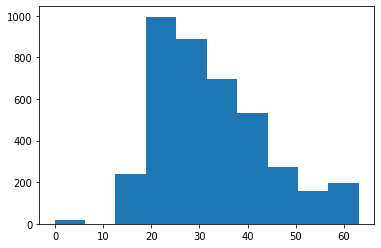

In [14]:
hist(df[:, f.SNR_p])

In [15]:
KL = df[:, {
    'KL_ban': log10(e)*dt.mean(f.log_prob_diff)
    },
     dt.by('kernel_name', 'kernel_M', 'use_oq', 'impose_null_integral')
]
KL

,kernel_name,kernel_M,use_oq,impose_null_integral,KL_ban
,▪▪▪▪,▪▪▪▪,▪,▪,▪▪▪▪▪▪▪▪
0,Matern12Kernel,16,0,0,186.622
1,Matern12Kernel,16,0,1,185.545
2,Matern12Kernel,16,1,0,183.838
3,Matern12Kernel,16,1,1,182.986
4,Matern12Kernel,32,0,0,177.628
5,Matern12Kernel,32,0,1,175.988
6,Matern12Kernel,32,1,0,173.335
7,Matern12Kernel,32,1,1,171.562
8,Matern12Kernel,64,0,0,171.731


Note that $M_\max$ is determined by $f_s$ and is about 150 for our application. (See test_pulse.ipynb.) Above that number the frequency content associated with a given basis function $\phi_m, m > M_\max$ is effectively contributing aliases to lower frequencies (because our data is assumed to be lowpass filtered).

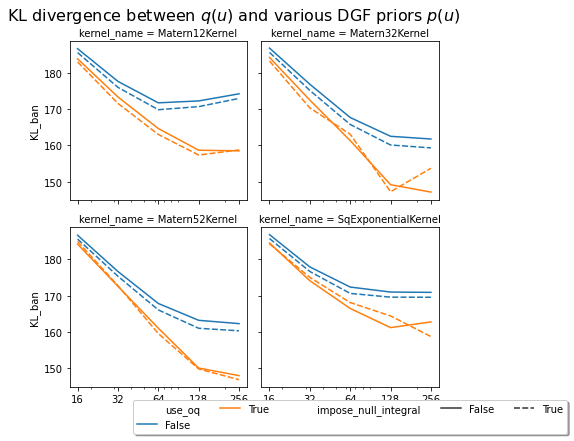

In [16]:
# TODO: error bars via df.log_prob_p_sd

g = sns.FacetGrid(KL.to_pandas(), col='kernel_name', col_wrap=2, margin_titles=True, despine=False)
g.map_dataframe(sns.lineplot, x="kernel_M", y="KL_ban", hue='use_oq', style='impose_null_integral', legend='brief')
g.set(xscale='log')
g.set(xticks=source.KERNEL_MS)
g.set_xticklabels(source.KERNEL_MS)
g.fig.suptitle('KL divergence between $q(u)$ and various DGF priors $p(u)$', size=16)
g.fig.subplots_adjust(top=.9)
legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5);

In [17]:
KL[:, :, dt.sort('KL_ban')]

,kernel_name,kernel_M,use_oq,impose_null_integral,KL_ban
,▪▪▪▪,▪▪▪▪,▪,▪,▪▪▪▪▪▪▪▪
0,Matern52Kernel,256,1,1,146.883
1,Matern32Kernel,256,1,0,147.185
2,Matern32Kernel,128,1,1,147.287
3,Matern52Kernel,256,1,0,147.993
4,Matern32Kernel,128,1,0,149.215
5,Matern52Kernel,128,1,1,149.825
6,Matern52Kernel,128,1,0,150.079
7,Matern32Kernel,256,1,1,153.729
8,Matern12Kernel,128,1,1,157.376


In [98]:
best_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = True
)

samples = source.posterior_of_fitted_lf_values([best_config])

[Memory]10366.5s, 172.8min: Loading posterior_of_fitted_lf_values...


In [99]:
# Cut out the noise power parameter
theta = samples[:,1:]

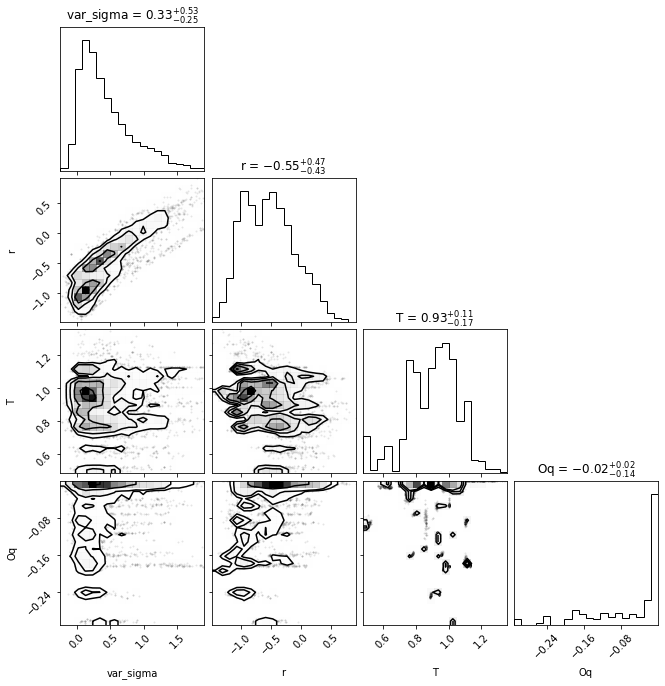

In [100]:
import corner

fig = corner.corner(
    log10(theta),
    labels=constants.SOURCE_PARAMS,
    show_titles=True,
    smooth=.2
)

In [113]:
# FIXME: use bounds from constants.py (eg Oq <= 1)
lo = floor(log10(np.min(theta,axis=0)))
hi = ceil(log10(np.max(theta,axis=0)))

lo, hi

(array([-1., -2.,  0., -1.]), array([ 2.,  1.,  2., -0.]))

In [114]:
bounds = 10**np.vstack([lo, hi]).T
bounds

array([[1.e-01, 1.e+02],
       [1.e-02, 1.e+01],
       [1.e+00, 1.e+02],
       [1.e-01, 1.e+00]])

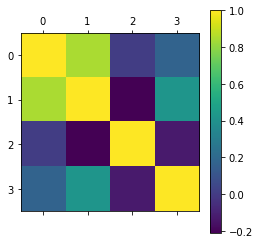

In [103]:
from dgf import bijectors

matshow(bijectors.get_log_stats(theta, bounds)['corr'])
colorbar();

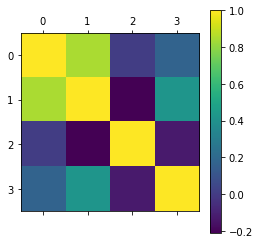

In [104]:
from dgf import bijectors

matshow(bijectors.get_log_stats(theta, source.SOURCE_BOUNDS)['corr'])
colorbar();

In [24]:
nonlinear_coloring = bijectors.fit_nonlinear_coloring_bijector(
    theta, bounds, 1111111
)

[Memory]25.4s, 0.4min   : Loading run_nested...


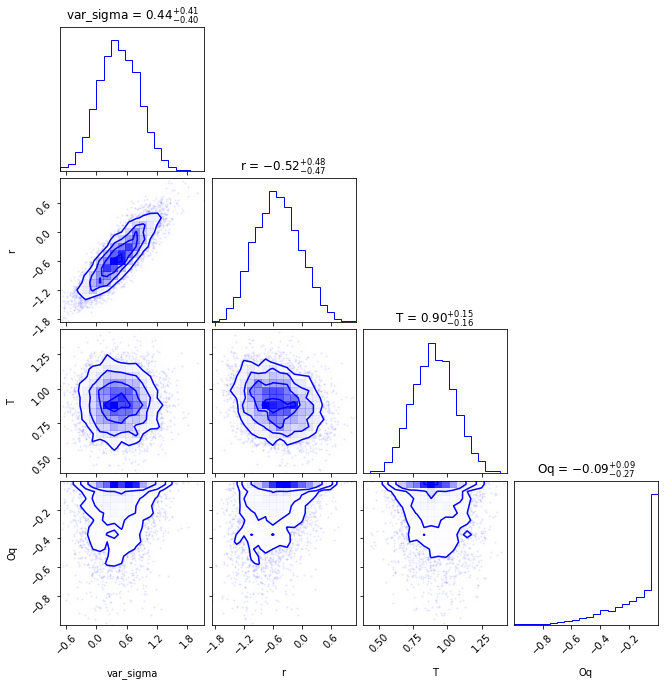

In [25]:
corner.corner(
    log10(np.array(nonlinear_coloring(randn(5000, 4)))),
    labels=constants.SOURCE_PARAMS,
    show_titles=True,
    smooth=.2,
    color="blue"
);

[Memory]13970.7s, 232.8min: Loading posterior_of_fitted_lf_values...
[Memory]13970.7s, 232.8min: Loading run_nested...


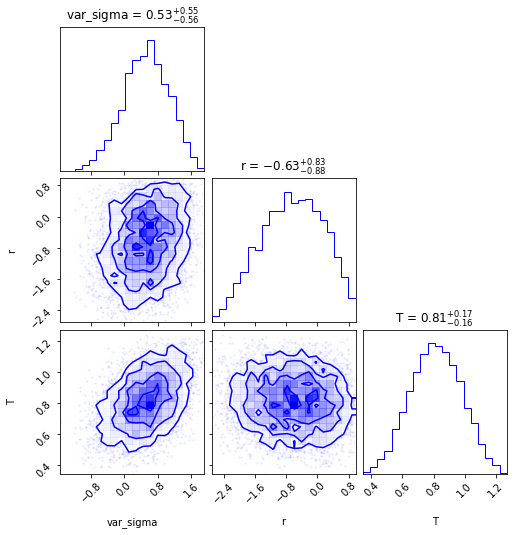

In [149]:
corner.corner(
    log10(np.array(source.fit_source_bijector(c)(randn(5000, 3)))),
    labels=source.SOURCE_PARAMS(c),
    show_titles=True,
    smooth=.2,
    color="blue"
);

[3.078141   0.42090285 7.06970668 0.8660042 ]


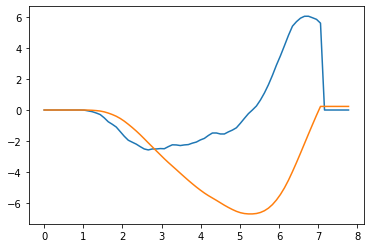

In [26]:
def scope(
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = True
):
    kernel = isokernels.resolve(kernel_name)
    
    theta = nonlinear_coloring.forward(randn(4))
    print(theta)
    var_sigma, r, T, Oq = theta
    var = var_sigma**2
    
    te = T*1.1
    t, dt = np.linspace(0., te, int(te*constants.FS_KHZ), retstep=True)
        
    R = core.kernelmatrix_root_gfd_oq(
        kernel, var, r, t, kernel_M, T, Oq, constants.BOUNDARY_FACTOR, impose_null_integral
    )
    
    u = R @ randn(kernel_M)
    plot(t, u)
    plot(t, cumsum(u)*dt)
    return u

u = scope(**best_config); # will be nan if Oq > 1

In [27]:
array(u)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -7.39077613e-03, -5.79210744e-02,
       -1.08029543e-01, -1.91876846e-01, -2.93925726e-01, -5.04292215e-01,
       -7.56823321e-01, -9.16616507e-01, -1.09669522e+00, -1.39202736e+00,
       -1.68969707e+00, -1.94472114e+00, -2.07337206e+00, -2.19801851e+00,
       -2.36077740e+00, -2.50864911e+00, -2.57029974e+00, -2.50723366e+00,
       -2.50822030e+00, -2.48247126e+00, -2.49279897e+00, -2.35792710e+00,
       -2.24077841e+00, -2.24906615e+00, -2.28804696e+00, -2.24710489e+00,
       -2.22642718e+00, -2.13343669e+00, -2.06362009e+00, -1.92694736e+00,
       -1.82717920e+00, -1.63998931e+00, -1.48131810e+00, -1.47899998e+00,
       -1.54213734e+00, -1.54308688e+00, -1.40776458e+00, -1.29305899e+00,
       -1.14367232e+00, -8.52222307e-01, -5.38127343e-01, -2.34051716e-01,
        2.37928265e-03,  

## Test bijector

In [214]:
NP = 7
config = next(source._yield_all_configs())
def randz():
    return randn(NP*source.SOURCE_NDIM(config))

b = source.source_trajectory_bijector(NP, config)

[Memory]15521.9s, 258.7min: Loading posterior_of_fitted_lf_values...
[Memory]15521.9s, 258.7min: Loading run_nested...


/home/marnix/thesis/py/dgf/bijectors.py:482: UserWarning: No observations to condition bijector on; returning original bijector
  warnings.warn("No observations to condition bijector on; returning original bijector")


In [215]:
b.forward(randz())

DeviceArray([[ 9.12403929,  0.043298  ,  9.58506375],
             [11.13463005,  0.03598305,  9.1876789 ],
             [ 8.5923378 ,  0.02772186,  9.29650411],
             [10.96199127,  0.02749981,  8.93611065],
             [10.12898266,  0.03007901,  8.78255597],
             [ 9.51461239,  0.03476177,  8.3383017 ],
             [12.05884251,  0.03527037,  8.44253904]], dtype=float64)

In [216]:
Th = b.forward(randz())[:,source.T_INDEX(config)]
Th = Th.at[0:3].set(nan)

In [217]:
bc = source.source_trajectory_bijector(NP, config, Th, False)

[Memory]15534.2s, 258.9min: Loading posterior_of_fitted_lf_values...
[Memory]15534.2s, 258.9min: Loading run_nested...


In [218]:
bc.forward(randz()), Th

(DeviceArray([[ 4.12404255,  0.04878862,  9.28560736],
              [ 3.14674246,  0.05187964, 10.02053634],
              [ 3.84160229,  0.05428577, 10.6859098 ],
              [ 3.34161937,  0.07702497,  9.51245399],
              [ 3.54460294,  0.07626688,  9.97092128],
              [ 3.36929017,  0.08647305, 10.02105708],
              [ 3.25862474,  0.08375186,  9.76108869]], dtype=float64),
 DeviceArray([        nan,         nan,         nan,  9.84395655,
              10.25342998, 10.02066054, 10.91476698], dtype=float64))

In [219]:
source.source_marginal_prior(config).sample(3,seed=jaxkey())

[Memory]15543.1s, 259.1min: Loading posterior_of_fitted_lf_values...
[Memory]15543.1s, 259.1min: Loading run_nested...


/home/marnix/thesis/py/dgf/bijectors.py:482: UserWarning: No observations to condition bijector on; returning original bijector
  warnings.warn("No observations to condition bijector on; returning original bijector")


DeviceArray([[9.71402575, 0.10037386, 9.13832682],
             [2.84474539, 0.42966857, 6.3078876 ],
             [3.1771132 , 7.62049786, 4.02022872]], dtype=float64)

In [221]:
source.source_trajectory_prior(5, config).sample(21,seed=jaxkey()).shape

[Memory]15554.7s, 259.2min: Loading posterior_of_fitted_lf_values...
[Memory]15554.7s, 259.2min: Loading run_nested...


(21, 5, 3)

## !! Get continuity in DGF waveform by correlating the amplitudes !!

This works!!

Need to implement this in the loglikelihood, because now the prior for the Hilbert GP amplitudes has changed. But it effictively works.

In [46]:
from dgf.prior import period

# Get source trajectory bijector
def source_trajectify(bstatic, num_pitch_periods):
    kernel_name, _, results =\
        period.fit_period_trajectory_kernel()

    envelope_lengthscale, envelope_noise_sigma =\
        period.maximum_likelihood_envelope_params(results)

    btraj = bijectors.nonlinear_coloring_trajectory_bijector(
        bstatic,
        num_pitch_periods,
        kernel_name,
        envelope_lengthscale,
        envelope_noise_sigma
    )

    return btraj

source_trajectify(nonlinear_coloring, 3).forward(randn(4*3))

DeviceArray([[ 4.66735412,  0.21712058, 12.30343715,  0.92969743],
             [ 6.32395662,  0.28642232, 12.28544438,  0.965481  ],
             [ 6.11207699,  0.29446469, 11.47860751,  0.96077243]],            dtype=float64)

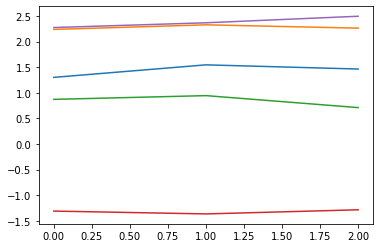

In [49]:
import tensorflow_probability.substrates.jax.bijectors as tfb

def get_amplitude_bijector(M):
    beye = bijectors.color_bijector(
        np.zeros(M), np.eye(M)
    )
    ampl_bijector = tfb.Chain([
        tfb.Identity(), beye
    ])
    return ampl_bijector

ampl_bijector = get_amplitude_bijector(5)
plot(source_trajectify(ampl_bijector, 3).forward(randn(5*3)))

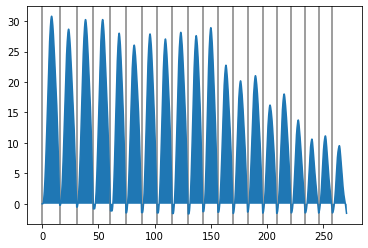

In [50]:
from lib import klatt

def translated_kernelmatrix_root_gfd_oq(theta, offset, alpha):
    var_sigma, r, T, Oq = theta
    var = var_sigma**2
    R = core.kernelmatrix_root_gfd_oq(
        alpha['kernel'], var, r,
        alpha['t'] - offset, alpha['M'], T,
        Oq, alpha['c'], alpha['impose_null_integral']
    )
    return R

def translated_gfd(a, theta, offset, alpha):
    R = translated_kernelmatrix_root_gfd_oq(theta, offset, alpha)
    return R @ a

def get_offset(theta):
    T = theta[:,-2]
    start = np.zeros(len(T))
    start[1:] = T[:-1]
    offset = np.cumsum(start)
    end = offset[-1] + T[-1]
    return offset, end

def gfd(a, theta, alpha):
    offset, end = get_offset(theta)
    alpha['offset'] = offset
    
    alpha['dt'] = 1/constants.FS_KHZ
    alpha['t'] = jnp.arange(0., end, alpha['dt'])
    
    gfd_waveforms = jax.vmap(
        translated_gfd,
        (0, 0, 0, None),
        0
    )(a, theta, offset, alpha)
    
    return np.sum(gfd_waveforms, axis=0)

def scope(
    num_pitch_periods,
    theta_bijector = nonlinear_coloring,
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = True
):
    assert use_oq == True
    
    # Get the trajectory bijectors for source theta and amplitudes
    btheta = source_trajectify(
        theta_bijector, num_pitch_periods
    )
    
    ampl_bijector = get_amplitude_bijector(kernel_M)
    bampl = source_trajectify(
        ampl_bijector, num_pitch_periods
    )
    
    # Sample source trajectory parameters and put in dict
    theta = btheta.forward(randn(4*num_pitch_periods))
    
    # Sample correlated amplitudes
    a = bampl.forward(randn(kernel_M*num_pitch_periods))
    
    # Set hyperparameters
    alpha = dict(
        kernel = isokernels.resolve(kernel_name),
        M = kernel_M,
        c = constants.BOUNDARY_FACTOR,
        impose_null_integral = impose_null_integral
    )
    
    wave = gfd(a, theta, alpha)
    
    for offset in alpha['offset']: axvline(offset, color='grey')
    fill_between(alpha['t'], np.cumsum(wave)*alpha['dt'])
    plot(alpha['t'], np.cumsum(wave)*alpha['dt'])
    #plot(alpha['t'], wave)
    
    return alpha['t'], wave

# Can handle only up to 250 pitch periods
# This is because we are lazy and just sum over the different
# pitch periods (we use offsetting)
# This can be rewritten to work for any amount of pitch peridos
t, wave = scope(20, **best_config) # will be nan if Oq > 1

klatt.play(t, wave)

In [31]:
#np.save("vtr/prior/dgf.npy", np.row_stack((t,wave)))

**Why these Klatt vowels sound so bad? One reason is the unrealistic -36 dB/oct spectral tilt of their 3 pole AP transfer function. In real speech this is closer to -2 dB/oct.**

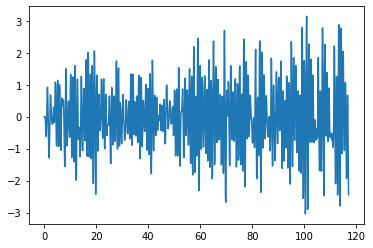

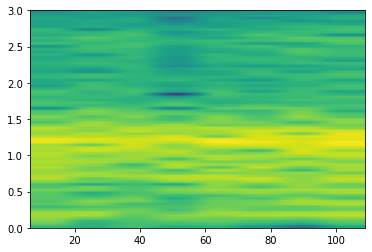

In [32]:
t, vowel = klatt.gen_vowel(10, wave, t)
plot(t, vowel)
show()
specgram(vowel, Fs=constants.FS_KHZ, scale='dB');
ylim(None, 3)
klatt.play(t, vowel)

## Conditioning on $T$

**UPDATE**: this is a partially observed MOGP (with $\hat T$ the noisy observation of $T$), a Hadamard GP. See "9.6.14 Hadamard product relation" in the Matrix cookbook.

---
(this is early reasoning)

Need to get $$p(\alpha|T_o) = p(\alpha_{-T}|T) p(T|T_o)$$ where $\alpha = (\sigma, r, T, O_q)$ are the source parameters and $T_o$ is Praat's estimate. We already have $p(T|T_o)$.

The correlations between $T$ and the other source parameters is weak (as can be seen in the corner plot and the fitted covariance matrix). This is by construction: we chose our parametrization maximally independent (e.g. $r$ is the *ratio* $\lambda/T$.) So conditioning might be overkill and we can assume independence.

**Update**: yes, we do, because then we can precalculate the conditional MVN $p(\alpha|T_o)$ once and for all and avoid doing this for each value of $T \sim p(T|\hat T)$ (even though we only need to update the mean function -- the covariance of $p(\alpha_{-T}|T)$ is actually independent of $T$ -- but the its mean does depend on it).

In [33]:
npp = 10

btraj = source_trajectify(nonlinear_coloring, npp)

# Generate mock observation to fix T from
print(constants.SOURCE_PARAMS)
observation = btraj.forward(randn(4*npp))

def observe_only(obs, j):
    print("Constraining", constants.SOURCE_PARAMS[j])
    ncol = obs.shape[1]
    new = np.array(obs, copy=True)
    new[:, np.arange(ncol) != j] = np.nan
    return new

observation = observe_only(observation, 2)
print(observation)

('var_sigma', 'r', 'T', 'Oq')
Constraining T
[[       nan        nan 6.75431273        nan]
 [       nan        nan 6.64076473        nan]
 [       nan        nan 6.79708941        nan]
 [       nan        nan 6.62284799        nan]
 [       nan        nan 6.82396784        nan]
 [       nan        nan 7.3743753         nan]
 [       nan        nan 7.11824231        nan]
 [       nan        nan 7.21885238        nan]
 [       nan        nan 7.36733131        nan]
 [       nan        nan 7.18213425        nan]]


There is indeed little correlation between $T$ and the other source parameters. But remember that $T | \hat{T}$ is the most important parameter of all source *and* filter parameters, because the alignment of the pitch periods directly influences each aspect of the entire inference. Thus conditioning on Praat's estimate $\hat T$ is important information for our $T$ source parameter, and that is extremely important in order to get $T$ right as fast as possible.

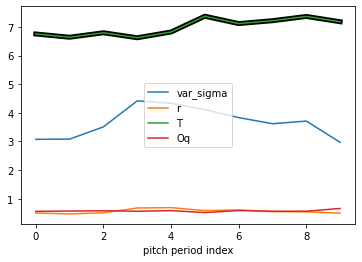

In [34]:
# Constrain exactly
cbtraj = bijectors.condition_nonlinear_coloring_trajectory_bijector(
    btraj, observation, np.eye(4)*0.
)

plot(observation, lw=5, color="black")
plot(cbtraj.forward(randn(4*npp)), label=constants.SOURCE_PARAMS)
xlabel("pitch period index")
legend();

## Constraint in terms of bans

In [35]:
def plot_dgf(i):
    s = lf_samples[i]

    p, t, u, log_prob_u = s['p'], s['t'], s['u'], s['log_prob_u']
    dt = t[1] - t[0]
    plot(t, cumsum(u)*dt)
    xlabel('time [msec]')
    title(f'log prob = {log_prob_u:.1f}');
    show()
    
def sample_analytical_source():
    plot_dgf(randint(len(lf_samples)))
    
def sample_nonparametric_source(impose_null_integral=True):
    T = 7.
    N = 300
    M = 128
    c = 2.25
    L = T*c
    t, dt = jnp.linspace(-1., T+3, N, retstep=True)

    kernel = isokernels.Matern32Kernel
    var = 0.5
    r = 1/np.pi*2
    scale = r*T
    
    oq = 1 - rand()*.7

    Ru = core.kernelmatrix_root_gfd_oq(kernel, var, scale, t, M, T, oq, c, impose_null_integral=impose_null_integral)

    a = randn(M)
    plot(t, cumsum(Ru @ a)*dt*10);
    
    log_prob_p = np.sum(scipy.stats.norm.logpdf(a))
    
    title(f'log prob = {log_prob_p:.1f}');
    xlabel('time [msec]')
    show()

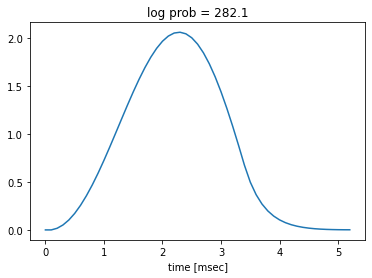

In [36]:
sample_analytical_source()

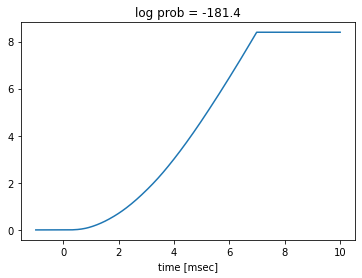

In [37]:
# Constraint = 3 bans => have to run this cell 1000 times to get one with null integral
sample_nonparametric_source(impose_null_integral=False)

## Show posterior samples of $u$

In [38]:
import dynesty.utils

def get_theta_mean(results):
    samples = results.samples
    weights = np.exp(results.logwt - results.logz[-1])

    # Compute weighted mean and covariance.
    mean, cov = dynesty.utils.mean_and_cov(samples, weights)

    return mean

@jax.jit
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

def covariance_matrix(R, noise_power):
    return noise_power*jnp.linalg.inv(R.T @ R + (1/noise_power)*jnp.eye(R.shape[1]))

def mvn_sample_and_log_prob(key, mean, covar):
    b = jax.random.multivariate_normal(key, mean, covar)
    log_prob_b = jax.scipy.stats.multivariate_normal(b, mean, covar)
    return b, log_prob_b

def sample_b(x, key):
    var, r, T, Oq, noise_power = x
    R = kernelmatrix_root_gfd_oq(kernel, var, r, t, M, T, Oq, c)
    b_mean = lstsq(R, u, noise_power)
    b_covar = covariance_matrix(R, noise_power)
    b, log_prob_b = mvn_sample_and_log_prob(key, mean, covar)
    return b, log_prob_b

In [39]:
import dynesty.plotting

def display_results(results):
    display(results.summary())
    display('Information (bans)', results.information[-1] * log10(e))

    VARIABLE_NAMES = source.MODEL_LF_SAMPLE_PARAMS
    fig, axes = dynesty.plotting.traceplot(
        results, show_titles=True,
        labels=VARIABLE_NAMES,
        #truths=[None, None, p['T0'], None, None],
        verbose=True
    )
    tight_layout()

    fg, ax = dynesty.plotting.cornerplot(results, labels=VARIABLE_NAMES)
    tight_layout()
    show()
    return results

def get(i, **kwargs):
    sample = lf_samples[i]
    t = sample['t']
    u = sample['u']
    
    config = dict(
        t = t,
        u = u,
        kernel_name = 'Matern32Kernel',
        kernel_M = 256,
        use_oq = True,
        impose_null_integral = True
    )
    
    config.update(kwargs)
    results = source.model_lf_sample(**config)
    return sample, config, results

def get_and_display_results(i, **kwargs):
    plot_dgf(i)
    sample, config, results = get(i, **kwargs)
    return display_results(results)

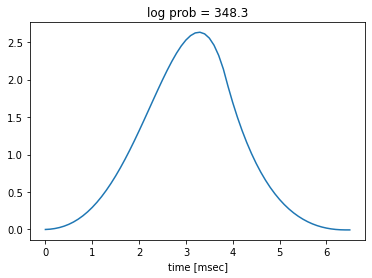

AttributeError: module 'dgf.prior.source' has no attribute 'model_lf_sample'

In [40]:
get_and_display_results(0, kernel_M=128);

In [ ]:
sample, config, results = get(0, kernel_M=128, use_oq=True, impose_null_integral=False)

display(results.logz[-1])
display(results.information[-1])

kernel = isokernels.resolve(config['kernel_name'])
M = config['kernel_M']
t, u = config['t'], config['u']
c = constants.BOUNDARY_FACTOR

noise_power, var, r, T, Oq = results.samples[-1] # Maximum likelihood

R = core.kernelmatrix_root_gfd_oq(kernel, var, r, t, M, T, Oq, c)
w_mean = lstsq(R, u, noise_power)
w_covar = covariance_matrix(R, noise_power)

plot(t, u, label='LF sample')
plot(t, R @ w_mean, label='mean')
#xlim(0, sample['p']['T0'])
k = 10
for i in range(k):
    x = random.multivariate_normal(w_mean, w_covar)
    plot(t, R @ x, color='black', alpha=1/k)
legend();

In [ ]:
kernel = isokernels.resolve(config['kernel_name'])
M = config['kernel_M']
t, u = config['t'], config['u']
c = constants.BOUNDARY_FACTOR

NUMFRAMES = 100
stride = int(floor(len(results.samples) / NUMFRAMES))
for frame in range(NUMFRAMES):
    figure()
    iteration = frame*stride
    
    noise_power, var, r, T, Oq = results.samples[iteration]

    R = core.kernelmatrix_root_gfd_oq(kernel, var, r, t, M, T, Oq, c)
    w_mean = lstsq(R, u, noise_power)
    w_covar = covariance_matrix(R, noise_power)

    title(f'iteration {iteration}')
    dt = t[1] - t[0]
    
    plot(t, u, label='LF sample')
    plot(t, R @ w_mean, label='mean')
    xlim(0, sample['p']['T0']*1.1)
    
    k = 10
    for i in range(k):
        x = random.multivariate_normal(w_mean, w_covar)
        plot(t, R @ x, color='black', alpha=1/k)
    legend()
    filename = f'dgf/prior/frame/{frame}.png'
    plt.savefig(filename)
    plt.clf()
    print(filename)